In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
import torch.nn as nn
from model import ScoreTransformer
import yaml
import argparse
from einops import rearrange
import re
import preprocessing
from preprocessing import event_2midi
import math
import os
from vocab import *

In [3]:
import re, music21

In [4]:
import IPython.display


In [5]:
import tension_calculation
import dataset

In [6]:
def show_score(pm):
    pm.write('./temp.mid')
    stream = music21.converter.parse('./temp.mid')
    stream.show()


def setup_musescore(musescore_path=None):
    if not is_ipython(): return

    import platform
    from music21 import environment
    from pathlib import Path

    system = platform.system()
    if system == 'Linux':
        import os
        os.environ['QT_QPA_PLATFORM'] = 'offscreen'  # https://musescore.org/en/node/29041

    existing_path = environment.get('musicxmlPath')
    if existing_path: return
    if musescore_path is None:
        if system == 'Darwin':
            app_paths = list(Path('/Applications').glob('MuseScore *.app'))
            if len(app_paths): musescore_path = app_paths[-1] / 'Contents/MacOS/mscore'
        elif system == 'Linux':
            musescore_path = '/usr/bin/musescore'

    if musescore_path is None or not Path(musescore_path).exists():
        print(
            'Warning: Could not find musescore installation. Please install musescore (see README) and/or update music21 environment paths')
    else:
        environment.set('musicxmlPath', musescore_path)
        environment.set('musescoreDirectPNGPath', musescore_path)


def is_ipython():
    try:
        get_ipython
    except:
        return False
    return True


def is_colab():
    try:
        import google.colab
    except:
        return False
    return True

In [7]:
setup_musescore()

In [201]:
tension_calculation.cal_tension??

In [283]:
vocab = WordVocab(all_tokens)

import tension_calculation
import dataset

def gen_nopeek_mask(length):
    """
     Returns the nopeek mask
             Parameters:
                     length (int): Number of tokens in each sentence in the target batch
             Returns:
                     mask (arr): tgt_mask, looks like [[0., -inf, -inf],
                                                      [0., 0., -inf],
                                                      [0., 0., 0.]]
     """
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask

def cal_track_control(file_events,pm):


    file_events = preprocessing.remove_control_event(file_events.tolist())
    r = re.compile('i_\d')

    track_program = list(filter(r.match, file_events))
    num_of_tracks = len(track_program)



    file_events = np.array(file_events)

    #     print(f'number of bars is {len(bar_pos)}')
    #     print(f'time signature is {file_event[1]}')
    bar_length = int(file_events[1][0])
    bar_pos = np.where(file_events == 'bar')[0]
    if bar_length != 6:
        bar_length = bar_length * 4 * len(bar_pos)
    else:
        bar_length = bar_length / 2 * 4 * len(bar_pos)
    #     print(f'bar length is {bar_length}')

    track_events = {}

    for i in range(num_of_tracks):
        track_events[f'track_{i}'] = []
    track_names = list(track_events.keys())
    for bar_index in range(len(bar_pos) - 1):
        bar = bar_pos[bar_index]
        next_bar = bar_pos[bar_index + 1]
        bar_events = file_events[bar:next_bar]
        #         print(bar_events)

        track_pos = []

        for track_name in track_names:
            if len(np.where(track_name == bar_events)[0]) == 0:
                print(bar_events)
            track_pos.append(np.where(track_name == bar_events)[0][0])
        #         print(track_pos)
        for track_index in range(len(track_names) - 1):
            track_event = bar_events[track_pos[track_index]:track_pos[track_index + 1]]
            track_events[track_names[track_index]].append(track_event)
        #             print(track_event)
        else:
            track_index += 1
            track_event = bar_events[track_pos[track_index]:]
            #             print(track_event)
            track_events[track_names[track_index]].append(track_event)

    densities = dataset.note_density(track_events, bar_length)
    density_category = dataset.to_category(densities, dataset.control_bins)

    occupation_rate, polyphony_rate = dataset.occupation_polyphony_rate(pm)
    occupation_category = dataset.to_category(occupation_rate, dataset.control_bins)
    polyphony_category = dataset.to_category(polyphony_rate, dataset.control_bins)
    pitch_register_category = dataset.pitch_register(track_events)
    #     print(densities)
    #     print(occupation_rate)
    #     print(polyphony_rate)
    #     print(density_category)
    #     print(occupation_category)
    #     print(polyphony_category)

    #     key_token =  key_to_token[key]

    density_token = [f'd_{category}' for category in density_category]
    occupation_token = [f'o_{category}' for category in occupation_category]
    polyphony_token = [f'y_{category}' for category in polyphony_category]
    pitch_register_token = [f'r_{category}' for category in pitch_register_category]

    track_control_tokens = density_token + occupation_token + polyphony_token + pitch_register_token

    print(track_control_tokens)







def cal_bar_control(target_name, generated_name):


    result = tension_calculation.extract_notes(target_name, 3)


    pm, piano_roll, sixteenth_time, beat_time, down_beat_time, beat_indices, down_beat_indices = result

    key_name = tension_calculation.all_key_names

    result_target = tension_calculation.cal_tension(
        target_name, piano_roll, sixteenth_time, beat_time, beat_indices, down_beat_time,
        down_beat_indices, './', -1, key_name)

    total_tension_target, diameters_target, _, key_name_target, key_change_time_target, key_change_bar_target, key_change_name_target = result_target

    target_tensile_category = dataset.to_category(total_tension_target, dataset.tensile_bins)
    target_diameter_category = dataset.to_category(diameters_target, dataset.tensile_bins)

    result = tension_calculation.extract_notes(generated_name, 3)

    pm, piano_roll, sixteenth_time, beat_time, down_beat_time, beat_indices, down_beat_indices = result

    key_name = tension_calculation.all_key_names

    result_generated = tension_calculation.cal_tension(
        target_name, piano_roll, sixteenth_time, beat_time, beat_indices, down_beat_time,
        down_beat_indices, './', -1, key_name)

    total_tension_generated, diameters_generated, _, key_name_generated, key_change_time_generated, key_change_bar_generated, key_change_name_generated = result_generated

    generated_tensile_category = dataset.to_category(total_tension_generated, dataset.tensile_bins)
    generated_diameter_category = dataset.to_category(diameters_generated, dataset.tensile_bins)



    print(f'target key {key_name_target}, generated key {key_name_generated}')

    return generated_tensile_category, generated_diameter_category,target_tensile_category,target_diameter_category


def nucleus(probs, p):
    probs /= (sum(probs) + 1e-5)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][0] + 1
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:]
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return word


def sampling(logit, p=None, t=1.0):
    logit = logit.squeeze().cpu().numpy()
    probs = softmax_with_temperature(logits=logit, temperature=t)

    if p is not None:
        cur_word = nucleus(probs, p=p)
    else:
        cur_word = weighted_sampling(probs)
    return cur_word


def softmax_with_temperature(logits, temperature):
    probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    return probs


def weighted_sampling(probs):
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    word = np.random.choice(sorted_index, size=1, p=sorted_probs)[0]
    return word


def get_mask_track_name(mask_tracks,mask_idx):
    total_tracks = 0
    for one_bar_tracks in mask_tracks:
        for track in one_bar_tracks:
            if total_tracks == mask_idx:
                if track == 0:
                    #tensile
                    return 's_'
                if track == 1:
                    #diameter
                    return 'a_'
                return f'track_{track-2}'
            else:
                total_tracks += 1

def get_bar_duration(meter):
    if meter == 6:
        return 3
    else:
        return meter


def total_duration(duration_list,duration_name_to_time):
    total = 0
    if duration_list:

        for duration in duration_list:
            total += duration_name_to_time[duration]
    return total

def clear_pitch_duration_event(
                               curr_time,
                               previous_duration,
                               is_rest_s,
                               duration_list,
                               duration_name_to_time):
    if is_rest_s:
        duration = total_duration(duration_list,duration_name_to_time)
        curr_time -= previous_duration

    else:
        duration = total_duration(duration_list,duration_name_to_time)

    curr_time += duration
    previous_duration = duration

    return curr_time,previous_duration

def prediction(model,event,token_type,device):
    src, tgt_out = mask_category(event,token_type,mask_num=3,pos=0)
    src_token = []


    src.to(device)
    tgt_out.to(device)

    target_output = []
    for i, token_idx in enumerate(tgt_out):
        target_token = vocab.index2char(token_idx.item())
        target_output.append(target_token)
    print('target output is:')
    for token in target_output:
        if token[0] == 'k':
            print(f'target key is {all_key_names[int(token[2:])]}')
        else:
            print(token)

    for i, token_idx in enumerate(src):
        src_token.append(vocab.index2char(token_idx.item()))

    src_masked_times = torch.sum(src == vocab.char2index('m_0')).item()
    tgt_inp = []
    tgt_inp_token = []
    weight_list = []
    generate_times = 0

    with torch.no_grad():
        mask_idx = 0

        while mask_idx < src_masked_times:
            tgt_inp.append(vocab.char2index('m_0'))

            sampling_times = 0
            output,weights = model_generate(model, src, tgt_inp,device=device,return_weights=True)
            index = sampling(output[-1], 0.9)
            sampling_times += 1

            output_token = vocab.index2char(index)
            # print(output_token)
                # print(event)

            while vocab.token_class_ranges[index] not in token_type and sampling_times < 10:
                index = sampling(output[-1], 0.9)
                output_token = vocab.index2char(index)
                sampling_times += 1



            if sampling_times < 10:
                tgt_inp.append(index)
                mask_idx += 1
                weight_list.append(weights)
            else:
                print(f'generate again, generate time is {generate_times}')
                generate_times += 1
                tgt_inp.pop()
                if generate_times > 5:
                    print(f'fail to generate track {mask_idx} after 5 times')
                    tgt_inp.append(index)
                    mask_idx += 1

                # i += 1
    generated_output = []



    for i, token_idx in enumerate(tgt_inp):
        tgt_inp_token.append(vocab.index2char(token_idx))
        if token_idx != 2:
            output_token = vocab.index2char(token_idx)
            generated_output.append(output_token)



    print('generated output is:')
    for token in generated_output:
        if token[0] == 'k':
            print(f'generated key is {all_key_names[int(token[2:])]}')
        else:
            print(token)



    # print(f'generation {generated_output}')
    # print(f'target {target_output}')


    return src_token, generated_output, target_output, tgt_inp_token,weight_list


def generate(model,event,mask_bars,mask_tracks,mask_tensile,mask_diameter,device):
    src, tgt_out,mask_bars,mask_tracks = mask_bar_and_track(event, mask_bars=mask_bars, mask_tracks=mask_tracks,mask_tensile=mask_tensile,mask_diameter=mask_diameter)


    src.to(device)
    tgt_out.to(device)

    duration_name_to_time, duration_time_to_name, duration_times, bar_duration = preprocessing.get_note_duration_dict(
        1, (int(event[1][0]), int(event[1][2])))

    src_masked_track = torch.sum(src == vocab.char2index('m_0')).item()
    tgt_inp = []
    generate_times = 0


    with torch.no_grad():
        mask_idx = 0
        while mask_idx < src_masked_track:

        # for mask_idx in range(src_masked_track):
            this_tgt_inp = []

            this_tgt_failure = False
            mask_track_name = get_mask_track_name(mask_tracks,mask_idx)
            # i = 0
            this_tgt_inp.append(vocab.char2index('m_0'))

            curr_time = 0
            previous_duration = 0

            in_duration_event = False
            is_rest_s = False

            in_pitch_event = False

            duration_list = []

            while this_tgt_inp[-1] != vocab.char2index('<eos>') and len(this_tgt_inp) < 500:
                sampling_times = 0
                output = model_generate(model, src, tgt_inp + this_tgt_inp,device)
                index = sampling(output[-1], 0.9)
                sampling_times += 1

                event = vocab.index2char(index)
                # print(event)

                if len(this_tgt_inp) == 1:
                    if mask_track_name in ['s_','a_']:
                        compare_event = event[:2]
                    else:
                        compare_event = event
                    if compare_event != mask_track_name:
                        while compare_event != mask_track_name and sampling_times < 10:
                            index = sampling(output[-1], 0.9)
                            event = vocab.index2char(index)
                            sampling_times += 1
                            if mask_track_name in ['s_', 'a_']:
                                compare_event = event[:2]
                            else:
                                compare_event = event
                        if compare_event != mask_track_name:
                            sampling_times = 0
                            while compare_event != mask_track_name and sampling_times < 10:
                                output = model_generate(model, src, tgt_inp + this_tgt_inp,device)
                                index = sampling(output[-1], 0.9)
                                event = vocab.index2char(index)
                                sampling_times += 1
                                if mask_track_name in ['s_', 'a_']:
                                    compare_event = event[:2]
                                else:
                                    compare_event = event
                            if compare_event != mask_track_name:
                                print(f'{compare_event} is not equal to {mask_track_name}')
                                print(f'mask {mask_idx} needs to be generated again')
                                this_tgt_failure = True


                if event in pitches:
                    in_pitch_event = True
                    if in_duration_event:
                        curr_time, previous_duration = clear_pitch_duration_event(
                            curr_time,
                            previous_duration,
                            is_rest_s,
                            duration_list,duration_name_to_time)

                        duration_list = []

                        in_duration_event = False
                        is_rest_s = False

                if event in duration_name_to_time.keys():
                    if not in_duration_event and not in_pitch_event:
                        # generate a pitch event token
                        while event not in pitches and sampling_times < 10:
                            index = sampling(output[-1], 0.9)
                            event = vocab.index2char(index)
                            sampling_times += 1
                        if event not in pitches:
                            sampling_times = 0
                            while event not in pitches and sampling_times < 10:
                                output = model_generate(model, src, tgt_inp + this_tgt_inp,device)
                                index = sampling(output[-1], 0.9)
                                event = vocab.index2char(index)
                                sampling_times += 1
                            if event != pitches:
                                print(f'{event} is not pitch')
                                print(f'mask {mask_idx} needs to be generated again')
                                this_tgt_failure = True

                        in_pitch_event = True
                    else:
                        in_pitch_event = False
                        duration_list.append(event)
                        in_duration_event = True

                # an event not in duration event happens

                if event == 'rest_s':
                    is_rest_s = True

                if event == '<eos>':
                    if in_duration_event:
                        curr_time, previous_duration = clear_pitch_duration_event(
                            curr_time,
                            previous_duration,
                            is_rest_s,
                            duration_list,duration_name_to_time)

                    if mask_track_name not in ['s_','a_']:
                        if not math.isclose(curr_time,bar_duration):
                            print(f'{curr_time} is not equal to {bar_duration}')
                            print(f'mask {mask_idx} needs to be generated again')
                            this_tgt_failure = True

                this_tgt_inp.append(index)
            if this_tgt_inp[-1] == vocab.char2index('<eos>') and not this_tgt_failure:
                mask_idx += 1
                tgt_inp.extend(this_tgt_inp[:-1])
            else:
                print(f'generate again, generate time is {generate_times}')
                generate_times += 1
                if generate_times > 10:
                    print(f'fail to have correct track duration {mask_idx} after 10 times')
                    tgt_inp.extend(this_tgt_inp)
                    mask_idx += 1


    generated_output = []
    target_output = []
    src_token = []

    for i, token_idx in enumerate(tgt_inp):
        output_token = vocab.index2char(token_idx)
        generated_output.append(output_token)

    for i, token_idx in enumerate(tgt_out):
        target_token = vocab.index2char(token_idx.item())
        target_output.append(target_token)

    # print(f'generation {generated_output}')
    # print(f'target {target_output}')

    for i, token_idx in enumerate(src):
        src_token.append(vocab.index2char(token_idx.item()))
    return restore_marked_input(src_token,generated_output,target_output), mask_bars




def cal_duration(events,time_signature):
    duration_name_to_time, duration_time_to_name, duration_times, bar_duration = preprocessing.get_note_duration_dict(
        1, (time_signature[0], time_signature[2]))

    def total_duration(duration_list):
        total = 0
        if duration_list:

            for duration in duration_list:
                total += duration_name_to_time[duration]
        return total

    def clear_pitch_duration_event(
                                   curr_time,
                                   previous_duration,
                                   is_rest_s,
                                   duration_list):
        if is_rest_s:
            duration = total_duration(duration_list)
            curr_time -= previous_duration

        else:
            duration = total_duration(duration_list)

        curr_time += duration
        previous_duration = duration

        return curr_time,previous_duration


    for i, event in enumerate(events):


        if event in control_tokens:
            continue

        if event in duration_name_to_time.keys():
            duration_list.append(event)
            in_duration_event = True
            continue

        # an event not in duration event happens
        if in_duration_event:
            curr_time, previous_duration = clear_pitch_duration_event(
                                                                      curr_time,
                                                                      previous_duration,
                                                                      is_rest_s,
                                                                      duration_list)

            duration_list = []

            in_duration_event = False
            is_rest_s = False


        if event == 'rest_s':
            is_rest_s = True


        if event == '<eos>':
            return curr_time







def bar_track_validate(output_indices, index, mask_track_name, time_signature,total_duration):
    if len(output_indices) == 1:
        # index must match track name
        if vocab.char2index(index) != mask_track_name:
            return False
    if vocab.char2index(index) == '<eos>':
        duration = cal_duration(output_indices,time_signature)
        if total_duration != duration:
            return False
    return True

vocab size: 330


In [284]:


def restore_marked_input(src_token, generated_output, target_output):
    src_token = np.array(src_token)

    # restore with generated output
    restored_with_generated_token = src_token.copy()

    generated_output = np.array(generated_output)
    target_output = np.array(target_output)
    generation_mask_indices = np.where(generated_output == 'm_0')[0]

    if len(generation_mask_indices) == 1:

        mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
        generated_result_sec = generated_output[generation_mask_indices[0] + 1:]

        #         print(len(generated_result_sec))
        restored_with_generated_token = np.delete(restored_with_generated_token, mask_indices[0])
        for token in generated_result_sec[::-1]:
            #             print(token)
            restored_with_generated_token = np.insert(restored_with_generated_token, mask_indices[0], token)


    else:

        for i in range(len(generation_mask_indices) - 1):
            #         print(i)
            mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
            generated_result_sec = generated_output[generation_mask_indices[i] + 1:generation_mask_indices[i + 1]]

            #             print(len(generated_result_sec))
            #             print(mask_indices[i])
            restored_with_generated_token = np.delete(restored_with_generated_token, mask_indices[0])

            for token in generated_result_sec[::-1]:
                #                 print(token)
                restored_with_generated_token = np.insert(restored_with_generated_token, mask_indices[0], token)

        else:
            #         print(i)
            mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
            generated_result_sec = generated_output[generation_mask_indices[i + 1] + 1:]

            #             print(len(generated_result_sec))
            restored_with_generated_token = np.delete(restored_with_generated_token, mask_indices[0])
            for token in generated_result_sec[::-1]:
                #                 print(token)
                restored_with_generated_token = np.insert(restored_with_generated_token, mask_indices[0], token)

    # restore with target
    r = re.compile('(?:track_\d|a_|s_)')

    target_mask_names = list(filter(r.match, target_output))
    target_output = np.array(target_output)
    if '<pad>' in target_output:
        end_index = np.where(target_output == '<pad>')[0][0]
    else:
        end_index = len(target_output)
    target_output = target_output.tolist()
    start_index = 0
    target_mask_indices = []

    if len(set(target_mask_names)) == 1:
        for name in target_mask_names:
            result_pos = target_output.index(name, start_index, end_index)
            target_mask_indices.append(result_pos)
            start_index = result_pos+1

    else:
        for name in target_mask_names:
            result_pos = target_output.index(name, start_index, end_index)
            target_mask_indices.append(result_pos)
            start_index = result_pos
    # print(target_mask_indices)
    restored_with_target_token = src_token.copy()

    if len(target_mask_indices) == 1:
        mask_indices = np.where(restored_with_target_token == 'm_0')[0]
        target_result_sec = target_output[target_mask_indices[0]:end_index - 1]

        #         print(len(target_result_sec))
        restored_with_target_token = np.delete(restored_with_target_token, mask_indices[0])
        for token in target_result_sec[::-1]:
            #             print(token)
            restored_with_target_token = np.insert(restored_with_target_token, mask_indices[0], token)

    else:
        for i in range(len(target_mask_indices) - 1):

            mask_indices = np.where(restored_with_target_token == 'm_0')[0]
            target_result_sec = target_output[target_mask_indices[i]:target_mask_indices[i + 1] - 1]

            #             print(len(target_result_sec))
            #             print(mask_indices[i])
            restored_with_target_token = np.delete(restored_with_target_token, mask_indices[0])
            for token in target_result_sec[::-1]:
                #                 print(token)
                restored_with_target_token = np.insert(restored_with_target_token, mask_indices[0], token)

        else:
            mask_indices = np.where(restored_with_target_token == 'm_0')[0]
            target_result_sec = target_output[target_mask_indices[i + 1]:end_index - 1]

            #             print(len(target_result_sec))
            restored_with_target_token = np.delete(restored_with_target_token, mask_indices[0])
            for token in target_result_sec[::-1]:
                #                 print(token)
                restored_with_target_token = np.insert(restored_with_target_token, mask_indices[0], token)

                # restore with rest

    if src_token[1] == '4/4':
        fill_in_tokens = ['rest_e', 'whole']
    elif src_token[1] == '2/4':
        fill_in_tokens = ['rest_e', 'half']
    else:
        fill_in_tokens = ['rest_e', 'half', 'quarter']

    mask_indices = np.where(src_token == 'm_0')[0]
    restored_empty_fill = src_token.copy()

    for i in range(len(mask_indices)):

        # print(target_mask_names)
        mask_indices = np.where(restored_empty_fill == 'm_0')[0]


        # print(mask_indices)
        restored_empty_fill = np.delete(restored_empty_fill, mask_indices[0])
        if target_mask_names[i][0] == 't':
            for token in fill_in_tokens[::-1]:
                # print(token)
                restored_empty_fill = np.insert(restored_empty_fill, mask_indices[0], token)
                # print(target_mask_names[i])
        restored_empty_fill = np.insert(restored_empty_fill, mask_indices[0], target_mask_names[i])



    # for i, index in enumerate(mask_indices):
    #     if index > bar_pos[-1]:
    #         print(f'masked bar {len(bar_pos)} {track_names[i]}')
    #     else:
    #         bar_start_index = np.where(index < bar_pos)[0][0]
    #         print(f'masked bar {bar_start_index} {track_names[i]}')

    return restored_with_generated_token, restored_with_target_token, restored_empty_fill


def change_control(batch, control_change, control_tokens,mininum,maximum,mask_bars=None):
    new_tokens = []
    if mask_bars:
        cur_bar = 0

        for token in batch:
            if token in control_tokens:
                if cur_bar in mask_bars:
                    token_new_category = int(token[2:]) + control_change
                    if token_new_category < mininum:
                        token_new_category = 0
                    if token_new_category > maximum:
                        token_new_category = maximum
                    token_new_category = str(token_new_category)
                    token = token[:2] + token_new_category
                cur_bar += 1

            new_tokens.append(token)
    else:
        for token in batch:
            if token in control_tokens:

                token_new_category = int(token[2:]) + control_change
                if token_new_category < mininum:
                    token_new_category = 0
                if token_new_category > maximum:
                    token_new_category = maximum
                token_new_category = str(token_new_category)
                token = token[:2] + token_new_category
            new_tokens.append(token)

    return new_tokens


# mask song/track/bar control token, span=1 for all
def mask_category(event, token_type,mask_num=1,pos=0):
    tokens = []
    decoder_in = []
    decoder_target = []
    start_pos = 0
    total_masked_ratio = 0
    masked_num = 0
    mask_pos = 0
    while start_pos < len(event):
        if vocab.token_class_ranges[vocab.char2index(event[start_pos])] in token_type  and masked_num < mask_num:
            if mask_pos >= pos:
                masked_token = event[start_pos]
                tokens.append(vocab.mask_indices[0])
                decoder_target.append(vocab.char2index(masked_token))
                masked_num += 1


            else:
                tokens.append(vocab.char2index(event[start_pos]))

            mask_pos += 1
            total_masked_ratio += 1 / len(event)
            start_pos += 1

        else:
            tokens.append(vocab.char2index(event[start_pos]))
            start_pos += 1
    tokens = np.array(tokens)

    if len(decoder_target) > 0:
        decoder_target = np.array(decoder_target)
    else:
        print('no masked token')
        return None

    return torch.tensor(tokens).long(),torch.tensor(decoder_target).long()



def mask_bar_and_track(event, mask_bars=None, mask_tracks=None,mask_tensile=None,mask_diameter=None):
    # mask bar token (w/wo bar control token) and try to generate bar token

    total_tokens = []
    total_decoder_in = []
    total_decoder_target = []

    tokens = []
    decoder_in = []
    decoder_target = []
    masked_indices_pairs = []

    bar_pos = np.where(np.array(event) == 'bar')[0]



    r = re.compile('i_\d')

    track_program = list(filter(r.match, event))
    track_nums = len(track_program)

    if track_nums == 3:
        #         ratios = track_ratio[0]
        track_0_pos = np.where('track_0' == np.array(event))[0]
        track_1_pos = np.where('track_1' == np.array(event))[0]
        track_2_pos = np.where('track_2' == np.array(event))[0]
        all_track_pos = np.sort(np.concatenate([track_0_pos, track_1_pos, track_2_pos]))

    else:
        #         ratios = track_ratio[1]
        track_0_pos = np.where('track_0' == np.array(event))[0]
        track_1_pos = np.where('track_1' == np.array(event))[0]
        all_track_pos = np.sort(np.concatenate([track_0_pos, track_1_pos]))

    #     bar_number_prob = np.array(bar_ratio[:len(bar_pos)],dtype=float)
    #     if not np.any(bar_number_prob):
    #         bar_number_prob = np.ones(len(bar_pos))

    #     print(f'bar number prob is {bar_number_prob}')
    #     bar_number_prob /= np.sum(bar_number_prob)

    #     # if np.sum(bar_number_prob) != 1:
    #     #     print(bar_number_prob)
    #     # print(f'bar number prob is {bar_number_prob}')
    #     resample_counts = np.random.multinomial(1, bar_number_prob[:len(bar_pos)])
    #     bar_mask_number = np.where(resample_counts)[0][0] + 1
    #     # bar_mask_number = np.random.choice(range(len(bar_pos)), size=1, p=bar_ratio[:len(bar_pos)])
    #     bar_start_indices = np.sort(np.random.choice(len(bar_pos),size=bar_mask_number,replace=False))

    if mask_bars is None:
        mask_bars = range(len(bar_pos))
        print(mask_bars)
    else:
        if not isinstance(mask_bars,list):
            if mask_bars >= len(bar_pos):
                print(f'mask bar {mask_bars} is larger than total bar {len(bar_pos)}, mask bar 1 instead')
                mask_bars  = 1
            mask_bars = [mask_bars]
        else:
            if len(mask_bars) >= len(bar_pos):
                mask_bars = mask_bars[0:len(bar_pos)]

    for i, bar in enumerate(mask_bars):
        if bar > len(bar_pos) - 1:
            print(f'mask bar {bar} is larger than total bar {len(bar_pos)}, mask bar {i} instead')
            mask_bars[i] = i

    mask_bars = list(dict.fromkeys(mask_bars))

    if mask_tracks is None:
        mask_track = [i+2 for i in range(track_nums)]
        mask_tracks = [mask_track for _ in mask_bars]
    else:
        if not isinstance(mask_tracks,list):
            mask_tracks = [mask_tracks+2]
        else:
            mask_tracks = [track + 2 for track in mask_tracks]
        if len(mask_tracks) != len(mask_bars):
            mask_tracks = [mask_tracks for _ in mask_bars]

    if mask_tensile is not None:
        if len(mask_tensile) != len(mask_bars):
            mask_tensile = [mask_tensile[0] for _ in mask_bars]


    if mask_diameter is not None:
        if len(mask_diameter) != len(mask_bars):
            mask_diameter = [mask_diameter[0] for _ in mask_bars]



    # print(f'bar start indices is {bar_start_indices}')
    for i, bar_num in enumerate(mask_bars):
        # bar_start_index = np.random.choice(len(bar_pos))

        if bar_num == len(bar_pos) - 1:
            next_bar_start_pos = len(event)
        else:
            next_bar_num = bar_num + 1
            next_bar_start_pos = bar_pos[next_bar_num]

        bar_start_pos = bar_pos[bar_num]

        track_start_index = np.where(all_track_pos > bar_start_pos)[0][0]
        track_positions = all_track_pos[track_start_index:track_start_index + track_nums]

        track_positions = np.append(track_positions, next_bar_start_pos)


        start_pos = track_positions[0]
        track_positions = np.insert(track_positions, 0, start_pos - 1)
        track_positions = np.insert(track_positions, 0, start_pos - 2)
        track_with_bar_ctrl_pos = track_positions
        #         prob = random.random()
        #         # print(prob)
        #         if prob < ratios[0]:
        #             # select one track
        #             track_pos_select_index = [np.random.choice(track_num)]
        #         elif prob < ratios[0] + ratios[1]:
        #             # select two tracks
        #             track_pos_select_index = np.sort(np.random.choice(track_num, 2, replace=False))
        #         else:
        #             # select three tracks
        #             track_pos_select_index = np.arange(track_num)
        # print(track_nums)
        # print(bar_start_index)


        print(f'mask bar {bar_num + 1} track {np.array(mask_tracks[i]) - 2}')

        if mask_diameter[i]:
            print(f'mask bar {bar_num + 1} diameter')
            mask_tracks[i] = np.insert(mask_tracks[i],0,1)
        if mask_tensile[i]:
            print(f'mask bar {bar_num + 1} tensile')
            mask_tracks[i] = np.insert(mask_tracks[i],0,0)



        track_pos_select_index = mask_tracks[i]

        # if not isinstance(track_pos_select_index,list):
        #     track_pos_select_index = [track_pos_select_index]



        # if mask_diameter[i]:
        #     print(f'mask bar {bar_num + 1} diameter')
        #     track_pos_select_index = np.insert(track_pos_select_index,0,1)
        # if mask_tensile[i]:
        #     print(f'mask bar {bar_num + 1} tensile')
        #     track_pos_select_index = np.insert(track_pos_select_index,0,0)



        for track_pos_index in track_pos_select_index:

            track_start_pos = track_with_bar_ctrl_pos[track_pos_index]
            if track_pos_index + 1 == len(track_positions):
                print('why')
            track_end_pos = track_with_bar_ctrl_pos[track_pos_index + 1]
            # print(track_start_pos)
            # print(track_end_pos)
            masked_indices_pairs.append((track_start_pos, track_end_pos))
            # track_event = event[track_start_pos:track_end_pos]
            # print(track_event)

    token_events = event.copy()

    for masked_pairs in masked_indices_pairs:
        masked_token = event[masked_pairs[0]:masked_pairs[1]]
        # print(masked_token)
        decoder_in.append(vocab.mask_indices[0])
        for token in masked_token:
            decoder_in.append(vocab.char2index(token))
            decoder_target.append(vocab.char2index(token))
        else:
            decoder_target.append(vocab.eos_index)

    for masked_pairs in masked_indices_pairs[::-1]:
        # print(masked_pairs)
        # print(token_events[masked_pairs[0]:masked_pairs[1]])
        for pop_time in range(masked_pairs[1] - masked_pairs[0]):
            token_events.pop(masked_pairs[0])
        token_events.insert(masked_pairs[0], mask[0])

    for token in token_events:
        tokens.append(vocab.char2index(token))

    tokens = np.array(tokens)
    if len(decoder_in) > 0:
        decoder_in = np.array(decoder_in)
        decoder_target = np.array(decoder_target)
        # print('\n')
        # print(f'event length is {len(event)}')
        # print(f'tokens length is {len(tokens)}')
        # print(f'masked num is {masked_num}')
        # print(f'decoder_in length is {len(decoder_in)}')
        # print(f'decoder_out length is {len(decoder_target)}')
        # print(f'ratio is {(len(tokens) + len(decoder_in)) / len(event)}')
        total_tokens.append(tokens)
        total_decoder_in.append(decoder_in)
        total_decoder_target.append(decoder_target)

    # print(len(tokens) - len(np.where(output_label==2)[0]))
    # print(len(output_label) - len(np.where(output_label==2)[0])*2)
    return torch.tensor(total_tokens).long().squeeze(), torch.tensor(total_decoder_target).long().squeeze(), mask_bars,mask_tracks

def model_generate(model, src, tgt,device,return_weights=False):

    src = src.clone().detach().unsqueeze(0).long().to(device)
    tgt = torch.tensor(tgt).unsqueeze(0).to(device)
    tgt_mask = gen_nopeek_mask(tgt.shape[1])
    tgt_mask = tgt_mask.clone().detach().unsqueeze(0).to(device)


    output,weights = model.forward(src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None,
                           tgt_mask=tgt_mask)
    if return_weights:
        return output.squeeze(0).to('cpu'), weights.squeeze(0).to('cpu')
    else:
        return output.squeeze(0).to('cpu')

In [13]:
platform = 'local'
checkpoint_epoch = 19
config_folder = '/home/ruiguo/score_transformer/wandb/run-20210131_170940-20n3sybv/'


In [9]:
platform = 'local'
checkpoint_epoch = 15
config_folder = '/home/data/guorui/wandb/run-20210222_085344-3o58okar/'


In [10]:

with open(os.path.join(config_folder,"files/config.yaml")) as file:

    config = yaml.full_load(file)


In [11]:
model = ScoreTransformer(vocab.vocab_size, config['d_model']['value'], config['nhead']['value'], config['num_encoder_layers']['value'],
                                 config['num_encoder_layers']['value'], 2048, 2400,
                                 0.1, 0.1)

checkpoint = os.path.join(config_folder,f"files/checkpoint_{checkpoint_epoch}")
model_dict = torch.load(checkpoint)

model_state = model_dict['model_state_dict']
optimizer_state = model_dict['optimizer_state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in model_state.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v

# new_state_dict = model_state

model.load_state_dict(new_state_dict)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

window_size = int(16 / 2)

if platform == 'local':
    folder_prefix = '/home/ruiguo/'
else:
    folder_prefix = '/content/drive/MyDrive/'


test_batch_name = 'test_batches_0_0_1_new_bins'
test_length_name = 'test_batch_lengths_0_0_1_new_bins'


test_batches = pickle.load(open(folder_prefix + 'score_transformer/' + test_batch_name, 'rb'))

test_batch_lengths = pickle.load(open(folder_prefix + 'score_transformer/' + test_length_name, 'rb'))


print(f'test batch length is {len(test_batches)}')



test batch length is 1231


In [363]:
mask_bars = None
mask_tracks = [0]
mask_tensile = [0]
mask_diameter = [0]
total_num = 0

In [364]:

for index,batches in enumerate(test_batches[1006:]):
    for batch in batches:
        total_num += 1
        print(f'the {total_num} data')
        print(f'original track control is {batch[4:16]}')
        

        
        restored_token,mask_bars = generate(model, batch, mask_bars, mask_tracks,mask_tensile,mask_diameter, device)

        restored_with_generated_token, restored_with_target_token, restored_empty_fill = restored_token


        restored_with_target_pm,_ = event_2midi(restored_with_target_token.tolist())
        restored_with_target_pm.write(f'restore_target_{index}.mid')


        restored_with_generated_pm,_ = event_2midi(restored_with_generated_token.tolist())
        restored_with_generated_pm.write(f'restore_generated_{index}.mid')

        restored_with_empty_pm,_ = event_2midi(restored_empty_fill.tolist())
        restored_with_empty_pm.write(f'restore_empty_{index}.mid')



        generated_tensile_category, generated_diameter_category,target_tensile_category,target_diameter_category = cal_bar_control(f'restore_target_{index}.mid', f'restore_generated_{index}.mid')

        for bar in mask_bars:
            if bar < len(generated_tensile_category) and bar < len(generated_diameter_category):
                print(f'bar {bar+1}, target tensile is {target_tensile_category[bar]} , generated tensile is {generated_tensile_category[bar]} \n'
                      f'bar {bar+1}, target diameter is {target_diameter_category[bar]} , generated diameter is {generated_diameter_category[bar]} \n')

        print('generated track control')
        cal_track_control(restored_with_generated_token, restored_with_generated_pm)
        print('target track control')
        cal_track_control(restored_with_target_token, restored_with_target_pm)

        original_pm, _ = event_2midi(batch)
        original_pm.write(f'original_{index}.mid')

        # cal_track_control(np.array(batch), original_pm)
        break
    break


the 1 data
original track control is ['d_3', 'd_4', 'd_2', 'o_5', 'o_7', 'o_9', 'y_0', 'y_0', 'y_9', 'r_3', 'r_1', 'r_3']
range(0, 16)
mask bar 1 track [0]
mask bar 2 track [0]
mask bar 3 track [0]
mask bar 4 track [0]
mask bar 5 track [0]
mask bar 6 track [0]
mask bar 7 track [0]
mask bar 8 track [0]
mask bar 9 track [0]
mask bar 10 track [0]
mask bar 11 track [0]
mask bar 12 track [0]
mask bar 13 track [0]
mask bar 14 track [0]
mask bar 15 track [0]
mask bar 16 track [0]
4.25 is not equal to 4
mask 4 needs to be generated again
generate again, generate time is 0
3.75 is not equal to 4
mask 5 needs to be generated again
generate again, generate time is 1
3.75 is not equal to 4
mask 7 needs to be generated again
generate again, generate time is 2
3.75 is not equal to 4
mask 7 needs to be generated again
generate again, generate time is 3
3.75 is not equal to 4
mask 9 needs to be generated again
generate again, generate time is 4
3.75 is not equal to 4
mask 11 needs to be generated agai

In [365]:

IPython.display.Audio(restored_with_empty_pm.fluidsynth(fs=16000), rate=16000)


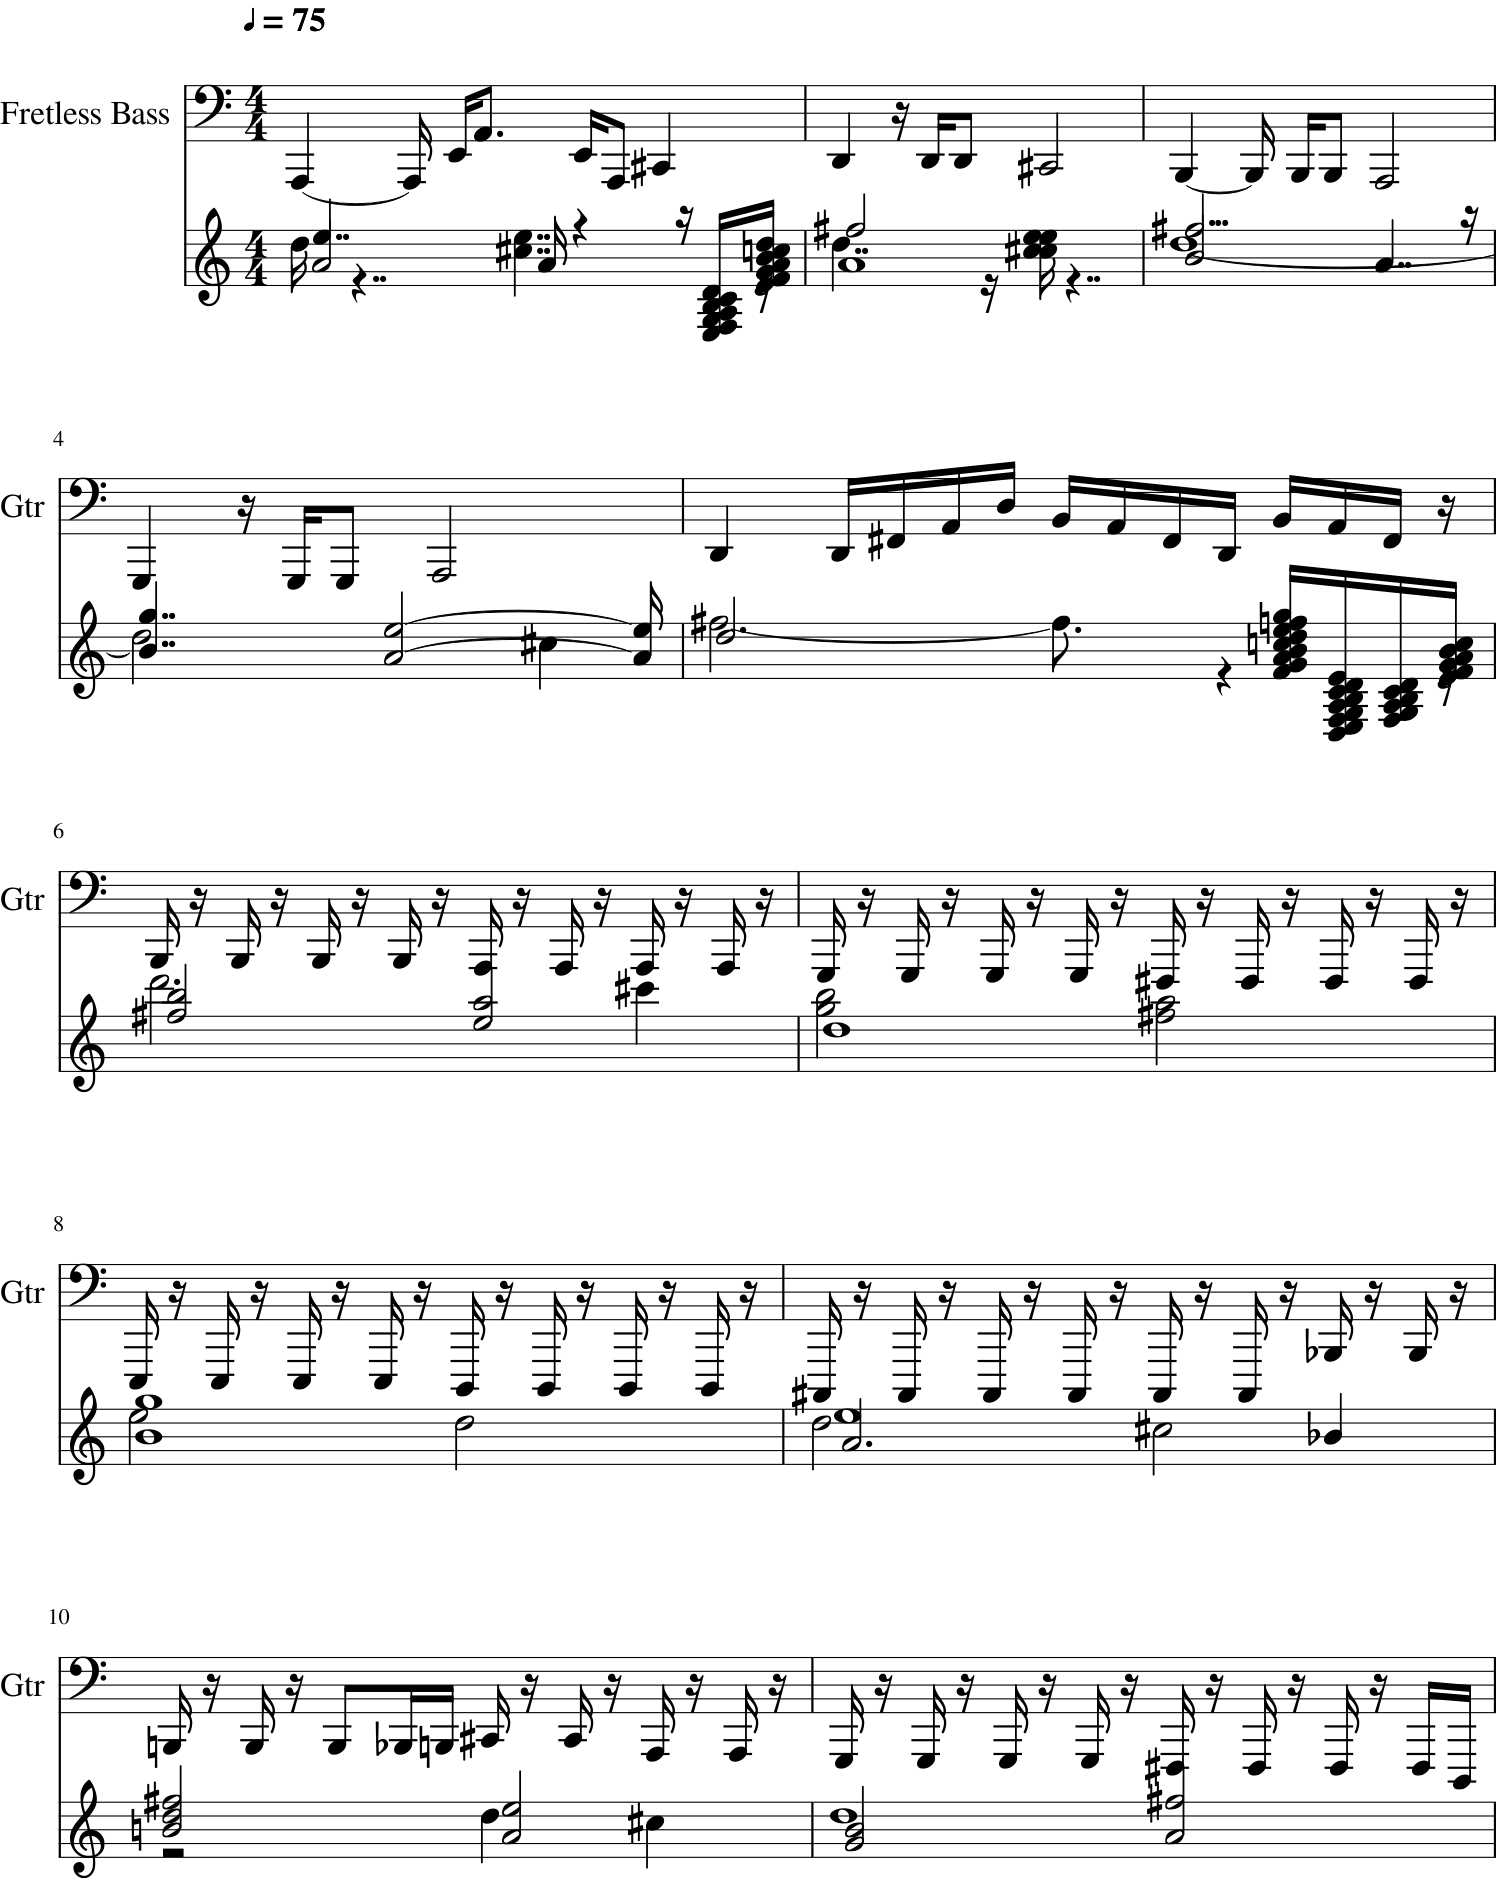

In [366]:
show_score(restored_with_empty_pm)

In [367]:

IPython.display.Audio(restored_with_target_pm.fluidsynth(fs=16000), rate=16000)


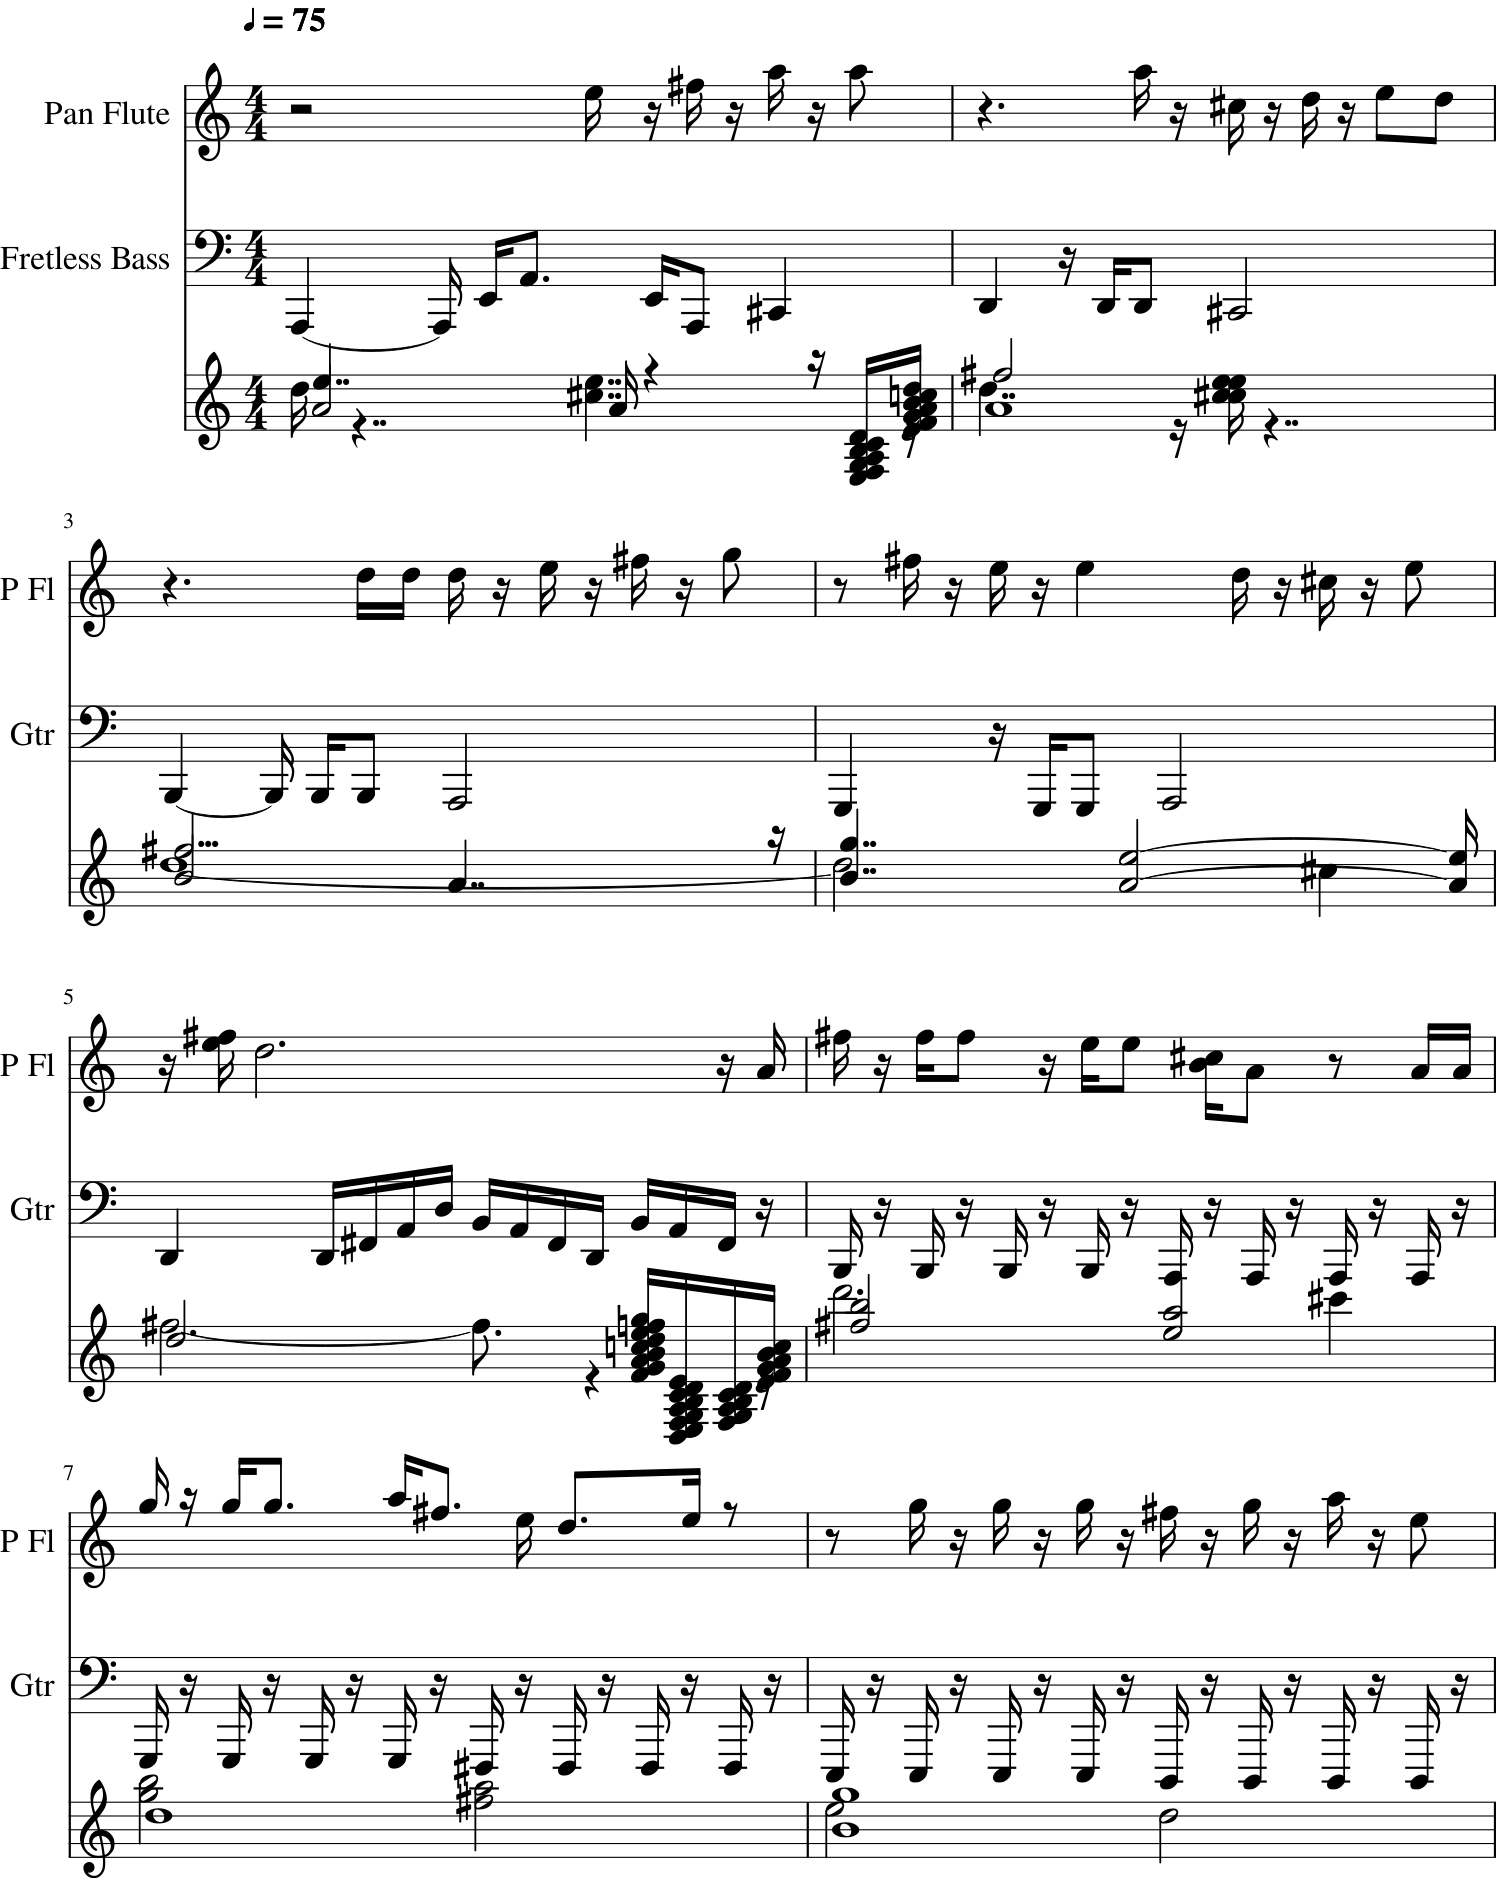

In [368]:
show_score(restored_with_target_pm)

In [369]:

IPython.display.Audio(restored_with_generated_pm.fluidsynth(fs=16000), rate=16000)


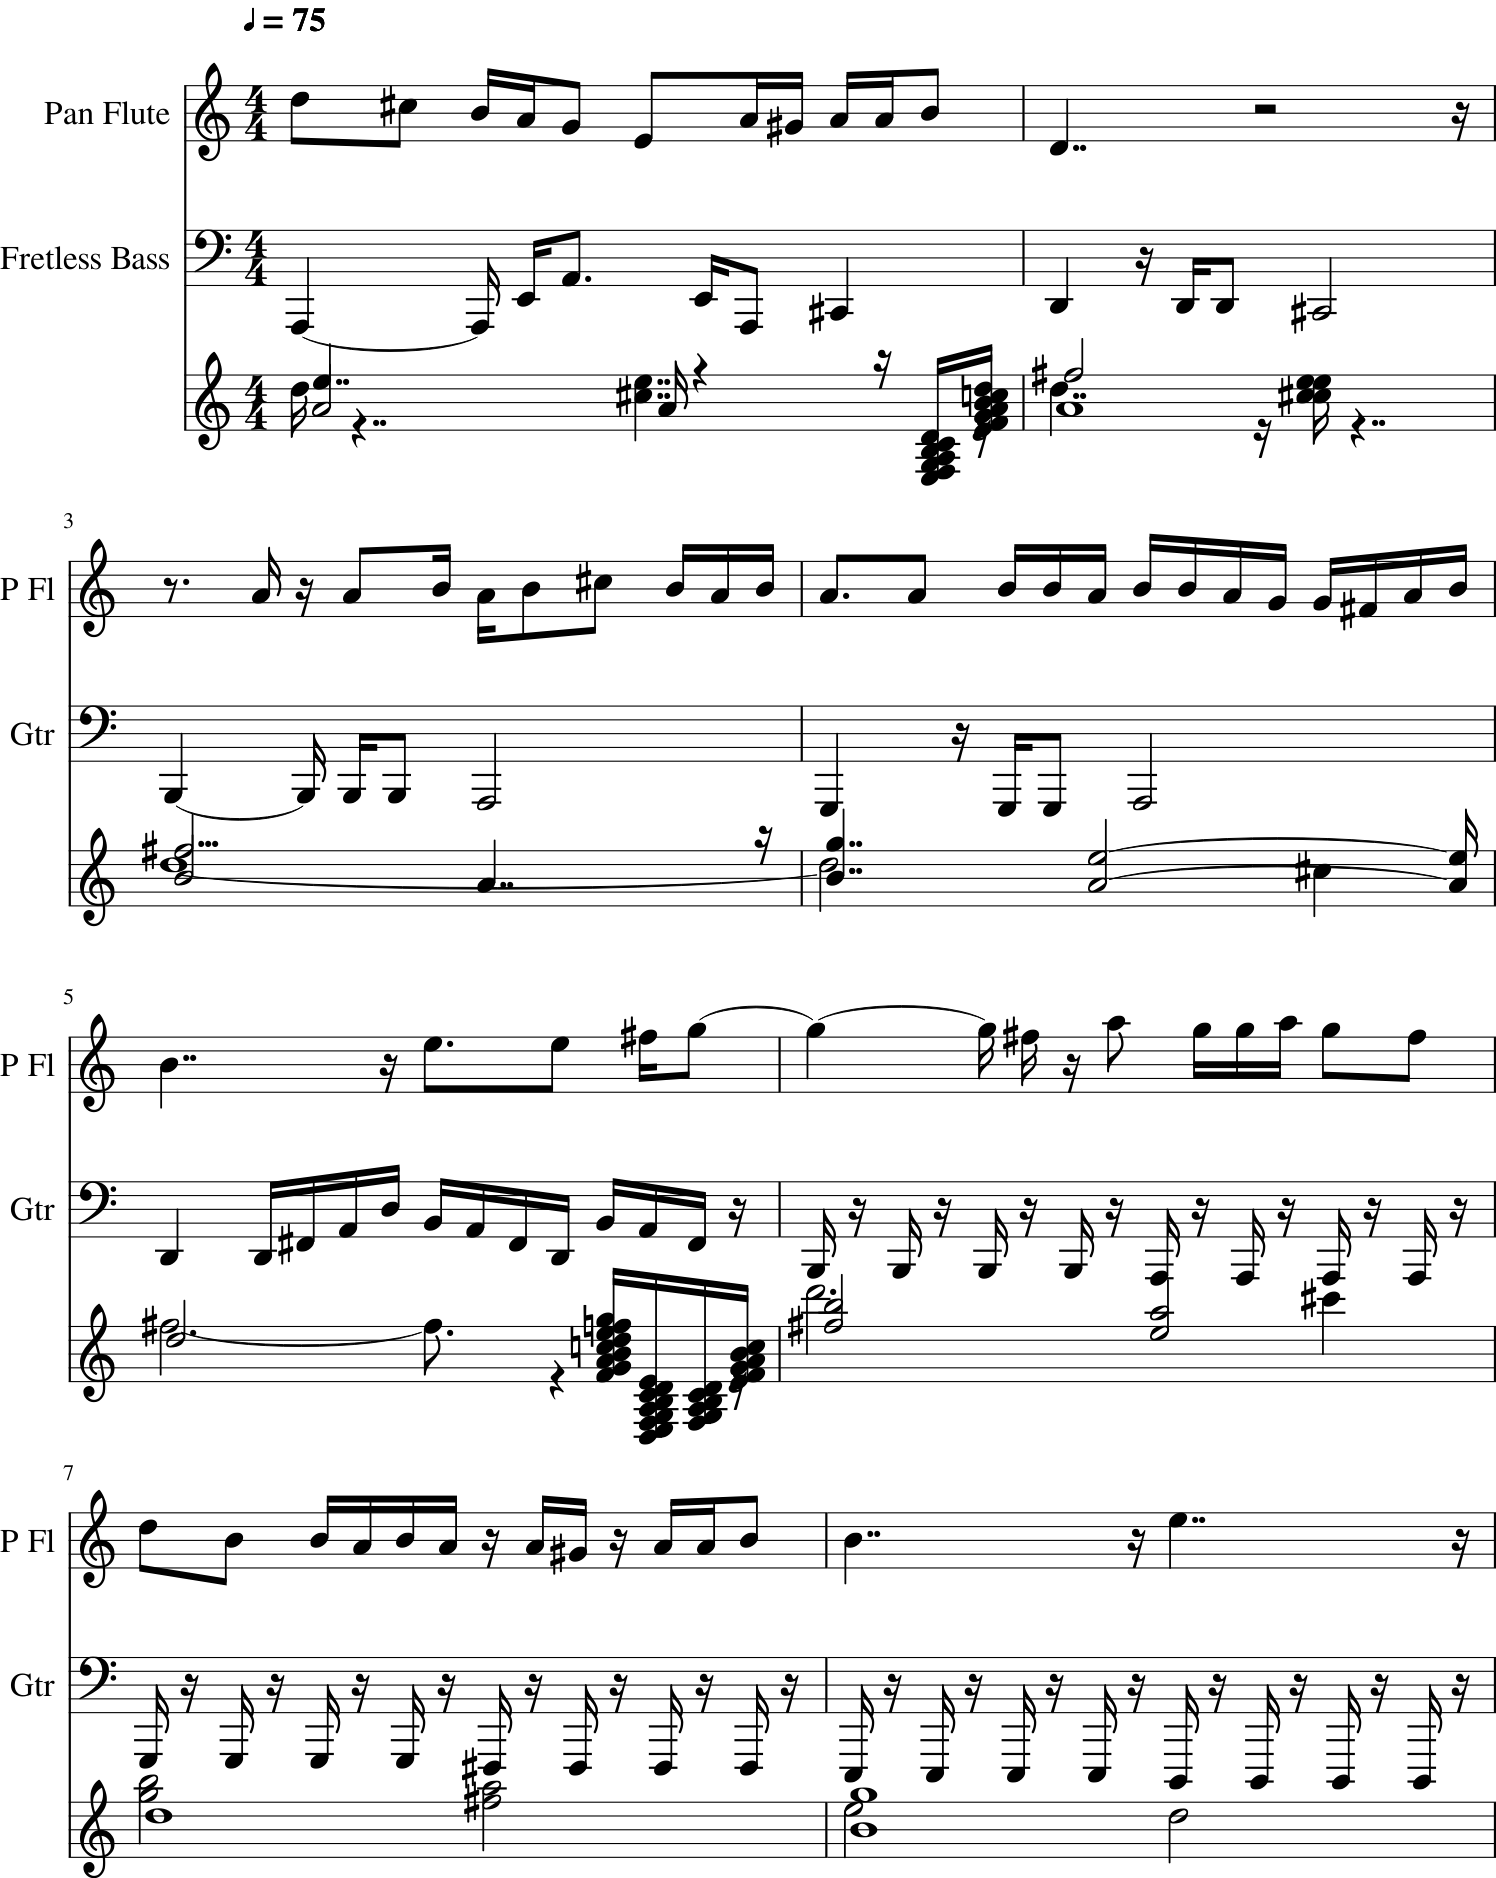

In [370]:
show_score(restored_with_generated_pm)

In [371]:
src_token = []
for i, token_idx in enumerate(src):  
    src_token.append(vocab.index2char(token_idx.item()))

NameError: name 'src' is not defined

In [91]:
src_token = np.array(src_token)

In [98]:
result_token = src_token.copy()

In [80]:
generated_output = np.array(generated_output)
target_output = np.array(target_output)

In [124]:
r = re.compile('track_\d')

In [138]:
target_mask_names = list(filter(r.match, target_output))
target_output = np.array(target_output)
end_index = np.where(target_output == '<pad>')[0][0]
target_output = target_output.tolist()
start_index = 0
target_mask_indices = []

for name in target_mask_names:
    result_pos = target_output.index(name, start_index, end_index)
    target_mask_indices.append(result_pos)
    start_index = result_pos
    

In [139]:
target_mask_indices

[0, 30, 52]

In [144]:
result_token

array(['bar', '4/4', 't_2', ..., 'p_61', 'p_64', 'half'], dtype='<U9')

In [148]:
np.where(src_token == 'm_0')[0]

array([21, 22, 23])

In [152]:
result_token = src_token.copy()
for i in range(len(target_mask_indices)-1):
    mask_indices = np.where(result_token == 'm_0')[0]
    target_result_sec = target_output[target_mask_indices[i]:target_mask_indices[i+1]-1]
    
    print(len(target_result_sec))
    print(mask_indices[i])
    result_token = np.delete(result_token,mask_indices[0])
    for token in target_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)
    
else:
    mask_indices = np.where(result_token == 'm_0')[0]
    target_result_sec = target_output[target_mask_indices[i+1]:end_index-1]
    
    print(len(target_result_sec))
    result_token = np.delete(result_token,mask_indices[0])
    for token in target_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)

29
21
sixteenth
p_71
sixteenth
p_70
sixteenth
rest_e
sixteenth
p_68
sixteenth
rest_e
eighth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
track_0
21
51
sixteenth
eighth
rest_e
sixteenth
p_39
sixteenth
p_39
sixteenth
rest_e
eighth
p_39
eighth
rest_e
eighth
p_35
sixteenth
p_35
sixteenth
eighth
p_35
track_1
15
half
p_61
p_58
half
rest_s
sixteenth
eighth
quarter
half
p_54
rest_s
half
p_59
p_63
track_2


In [116]:
pm,_ = event_2midi(result_token.tolist())
IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)